In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [112]:
def read_data(adr, y_name):
    df = pd.read_csv(adr)
    x = df.loc[:, df.columns != y_name]
    y = df.loc[:, df.columns == y_name]
    return x, y

x, y = read_data('heart.csv', 'target')
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [11]:
y.head()

,target
0,1
1,1
2,1
3,1
4,1


In [113]:
def shuffle(x, y):
    idx = np.random.permutation(x.index)
    x = x.reindex(idx)
    y = y.reindex(idx)
    return x, y

x, y = shuffle(x, y)
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
98,43,1,2,130,315,0,1,162,0,1.9,2,1,2
137,62,1,1,128,208,1,0,140,0,0.0,2,0,2
245,48,1,0,124,274,0,0,166,0,0.5,1,0,3
96,62,0,0,140,394,0,0,157,0,1.2,1,0,2
253,67,1,0,100,299,0,0,125,1,0.9,1,2,2


In [13]:
y.head()

,target
115,1
6,1
87,1
52,1
94,1


In [110]:
def data_split(x, y, frac):
    idx = np.random.permutation(x.index)
    train_idx = idx[:int(len(idx) * frac)]
    test_idx = idx[int(len(idx) * frac):len(idx)]
    
    train_x = x.iloc[train_idx, :]
    train_y = y.iloc[train_idx, :]
    test_x = x.iloc[test_idx, :]
    test_y = y.iloc[test_idx, :]
   
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = data_split(x, y, 0.8)    

In [16]:
def accuracy(y, y_pred):
    diff = (y == y_pred).to_numpy()
    return np.count_nonzero(diff) / len(y)

accuracy(test_y, test_y)

1.0

In [75]:
def confusion_matrix(y, y_pred):
    tp = np.count_nonzero((y_pred == True) & (y == True).to_numpy())
    fp = np.count_nonzero((y_pred == True) & (y == False).to_numpy())
    tn = np.count_nonzero((y_pred == False) & (y == False).to_numpy())
    fn = np.count_nonzero((y_pred == False) & (y == True).to_numpy()) 
    return tp, fp, tn, fn

confusion_matrix(test_y, test_y)

(36, 0, 25, 0)

In [18]:
def classification_report(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    f1_score = 2 * recall * precision / (recall + precision)
    return accuracy, recall, precision, specificity, f1_score  

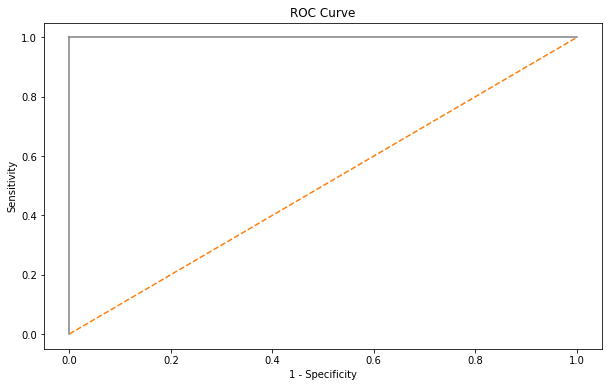

In [19]:
def roc_curve(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10,6))
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    plt.title('ROC Curve')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.plot(1 - spe, sen)
    plt.plot([0,1], ls='--')
    plt.plot([0,0],[1,0], c='.5')
    plt.plot([1,1], c='.5')
    plt.show()
    return

roc_curve(test_y, test_y)

In [21]:
def t_test(y1, y2, threshold):
    mean1 = np.mean(y1)
    mean2 = np.mean(y2)
    # do we need ddof =1 here in std?
    std1 = np.std(y1)
    std2 = np.std(y2)
    t_stat = (mean1 - mean2) / np.sqrt(std1**2 / len(y1) + std2**2 / len(y2))
    # compute p_value and reject or accept null hypotesis
    # https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
    # https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce   
    print(mean1, std1, t_stat)
    return

t_test(test_y, test_y, 0.8)

target    0.590164
dtype: float64 target    0.491803
dtype: float64 target    0.0
dtype: float64


In [ ]:
class KNN:
  def __init__(self, k):
    self.k = k
    
  def predict(self, test_x):
    test_x = self.scale_features(test_x)
    test_pred = pd.DataFrame(columns = ['target'], index = test_x.index)
    
    for i in range(0, len(test_x)):
        neighbor_indexes = self.find_neighbors(self.x, self.y, test_x.iloc[i], self.k) 
        majority = y.iloc[neighbor_indexes].mode()
        test_pred.at[test_x.index[i], 'target'] = majority.at[0, 'target']

    return test_pred

  def euclidean_distance(self, v1, v2):
    dif = v1 - v2
    return np.sqrt(np.sum(dif ** 2))

  def scale_features(self, x):
    return (x - x.min()) / (x.max() - x.min())

  def find_neighbors(self, x, y, test_row, k):
    dist = np.zeros(len(x))
    for i in range(0, len(x)):
        dist[i] = self.euclidean_distance(x.iloc[i], test_row)
    indexes = dist.argsort()[-k:][::-1]
    return indexes 

  def fit(self, x, y):
    self.x = self.scale_features(x)
    self.y = y

for i in range(1, 15):
    k1 = KNN(i)
    k1.fit(train_x, train_y)
    test_pred = k1.predict(test_x)
    test_pred.set_index(test_x.index)
    #print(test_pred)
    #print(test_y)
    print(accuracy(test_pred, test_y))


In [145]:
class Node:
    def __init__(self, pred):
        self.left_child = None
        self.right_child = None
        self.feature = None
        self.pred = pred
        self.bound = 0

class DecisionTree:
  def __init__(self, max_depth, threshold):
    self.max_depth = max_depth
    self.threshold = threshold
    
  def fit(self, x, y):
    self.tree = self.build_tree(x, y, 0) 
    
  def impurity(self, a, b):
    return 1.0 - (a / (a + b)) ** 2 - (b / (a + b)) ** 2
    
  def split(self, x, y):
    best_feature = None
    bound = None
    
    split_count = [y.target.value_counts()[0], y.target.value_counts()[1]]
    best_impurity = self.impurity(split_count[0], split_count[1])
    
    for feature in range(0, x.shape[1]):
        left_split_count = [0, 0]
        right_split_count = split_count.copy()
        x_numpy = x.copy().iloc[:, feature].to_numpy()
        y_numpy = y.copy().iloc[:, 0].to_numpy()
                
        thresholds, classes = zip(*sorted(zip(x_numpy, y_numpy)))
        
        for i in range(1, x.shape[0]):
            c = classes[i - 1]
            left_split_count[c] += 1
            right_split_count[c] -= 1
            impurity_left = self.impurity(left_split_count[0], left_split_count[1])
            impurity_right = self.impurity(right_split_count[0], right_split_count[1])
            impurity_total = (i * impurity_left + (x.shape[1] - i) * impurity_right) / x.shape[1]
            
            if thresholds[i] == thresholds[i - 1]:
                continue
                
            if impurity_total < best_impurity:
                best_impurity = impurity_total
                best_feature = feature
                bound = (thresholds[i] + thresholds[i - 1]) / 2
        
    
    return bound, best_feature

  def build_tree(self, x, y, depth):
    node = Node(pred = y.mode().at[0, 'target'])
    
    if y.target.value_counts().size == 1:
        return node
            
    if depth < self.max_depth and y.target.value_counts()[0] < self.threshold * y.shape[0]:
        
        bound, feature = self.split(x, y)
        if feature is not None:
            indices_left = x.iloc[:, feature] < bound
            
            left_x = x[indices_left]
            right_x = x[~indices_left]
            left_y = y[indices_left]
            right_y = y[~indices_left]
                        
            node.feature = feature
            node.bound = bound
            node.left_child = self.build_tree(left_x, left_y, depth + 1)
            node.right_child = self.build_tree(right_x, right_y, depth + 1)           

    return node
    
  def predict(self, test_x):
    test_pred = pd.DataFrame(columns = ['target'], index = test_x.index)
    
    for i in range(0, len(test_x)):
        node = self.tree
        while node.left_child:

            if test_x.iloc[i, node.feature] < node.bound:
                node = node.left_child
            else:
                node = node.right_child
        test_pred.at[test_x.index[i], 'target'] = node.pred
    
    return test_pred
    
d1 = DecisionTree(13, 0.8)
d1.fit(train_x, train_y)
test_pred = d1.predict(test_x)
print(accuracy(test_pred, test_y))

0.7704918032786885
